# WINE RECOMMANDER PROJECT

---

![](https://images.unsplash.com/photo-1519671482749-fd09be7ccebf?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=1350&q=80)

Photo by [Kelsey Chance](https://unsplash.com/@kchance8)

# Context

This project is related to a kaggle's project : [Wine Reviews](https://www.kaggle.com/zynicide/wine-reviews).

The objective here is to create a **wine recommandation model** based on the oenological description of a wine by a sommelier. This algorithm should be able to bring together wines that are similar on the aromatic level.

# Content

The data was scraped from the famous wine magazine [WineEnthusiast](https://www.winemag.com/?s=&drink_type=wine) during the week of June 15th, 2017 for year 2014 and 2015. 


The dataset contains **130k wine reviews** with variety, location, winery, price, points and description.
For the sake of computing power, the model is focused on french wines, but it is scallable and reproductible.

**Columns's labels**:

- Country
- Description
- Designation
- Points
- Price
- Province
- Region_1
- Region_2
- Taster_name
- Taster_twitter_handle
- Title	
- Variety
- Winery


# Sections 

1.**Data preparation and EDA**
2.**Preprocessing** (Spacy)
3.**Modeling** (TFIDF, Cosine Similarity)
4.**Model Prediction**
5.**Deployment** (Flask & Heroku) [link](https://samewineeverywhere.herokuapp.com/wine_app)

In [1]:
#Import useful librairies

#EDA
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import roundup

#Preprocessing
import spacy
import string
from spacy.lang.en import English

#Modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy import displacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise

# 1. EDA

## Overview

In [2]:
df = pd.read_csv("winemag-data-130k.csv", index_col=0)[:20000]

In [3]:
df.head(10)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,NaN,Kerin O’Keefe,@kerinokeefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo
7,France,This dry and restrained wine offers spice in p...,NaN,87,24.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Trimbach 2012 Gewurztraminer (Alsace),Gewürztraminer,Trimbach
8,Germany,Savory dried thyme notes accent sunnier flavor...,Shine,87,12.0,Rheinhessen,NaN,NaN,Anna Lee C. Iijima,NaN,Heinz Eifel 2013 Shine Gewürztraminer (Rheinhe...,Gewürztraminer,Heinz Eifel
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam


In [4]:
print(f"The dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")

The dataset contains 20000 rows and 13 columns.


In [5]:
df.columns

Index(['country', 'description', 'designation', 'points', 'price', 'province',
       'region_1', 'region_2', 'taster_name', 'taster_twitter_handle', 'title',
       'variety', 'winery'],
      dtype='object')

In [6]:
# Inspect the DataFrame columns (dtypes, and non-null values)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   country                19989 non-null  object 
 1   description            20000 non-null  object 
 2   designation            14298 non-null  object 
 3   points                 20000 non-null  int64  
 4   price                  18578 non-null  float64
 5   province               19989 non-null  object 
 6   region_1               16632 non-null  object 
 7   region_2               7714 non-null   object 
 8   taster_name            15917 non-null  object 
 9   taster_twitter_handle  15187 non-null  object 
 10  title                  20000 non-null  object 
 11  variety                20000 non-null  object 
 12  winery                 20000 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 2.1+ MB


In [7]:
# Describe briefly continuous variables

df.describe()

,points,price
count,20000.000000,18578.000000
mean,88.375600,35.230649
std,3.045372,43.237038
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,2500.000000


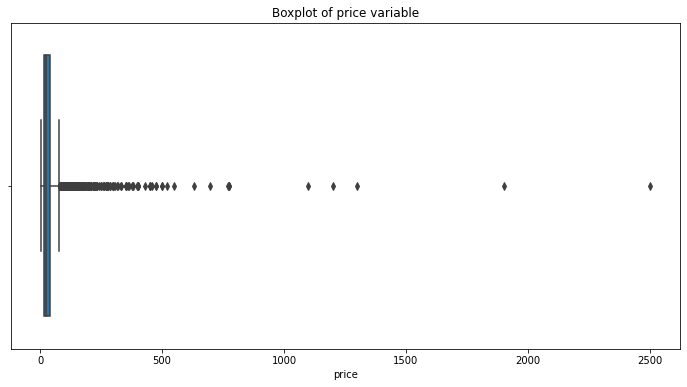

In [8]:
plt.figure(figsize=(12, 6))

sns.boxplot(x="price", data=df)

plt.title('Boxplot of price variable')
plt.show()

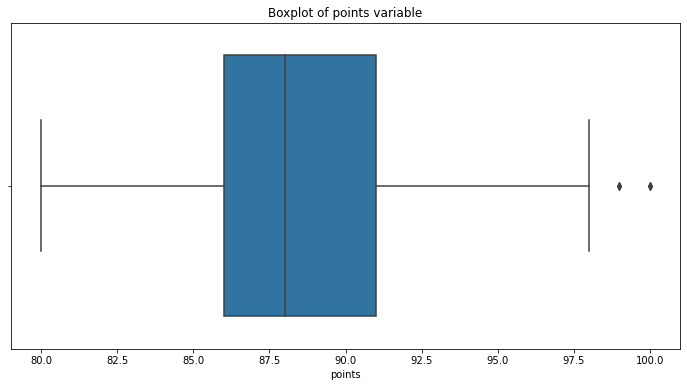

In [9]:
plt.figure(figsize=(12, 6))

sns.boxplot(x="points", data=df)

plt.title('Boxplot of points variable')
plt.show()

#### Interesting insights:

- The value of points varies between 80 and 100 (with small dispersion as standart deviation is around 3, and with both mean and median close to 88)
- The prices can vary a lot as they live in the range 4 - 2500 and the standard deviation is around 43.

Text(0, 0.5, 'Frequency')

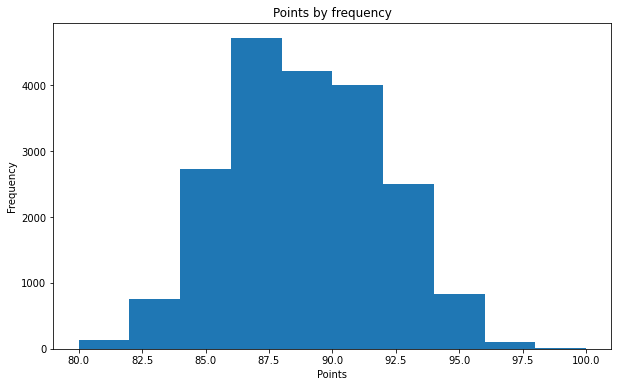

In [10]:
# Points by frequency

fig, ax = plt.subplots(figsize =(10,6))
ax.hist(df['points'])
ax.set_title('Points by frequency')
ax.set_xlabel('Points')
ax.set_ylabel('Frequency')

The graph confirms a small dispersion of points with a greatest part in the range 86-91.

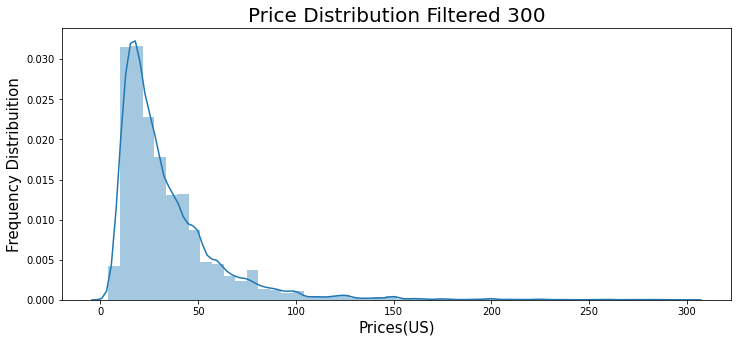

In [11]:
# Price by frequency

plt.figure(figsize=(12,5))

g = sns.distplot(df[df['price'] < 300]['price'])
g.set_title("Price Distribution Filtered 300", fontsize=20)
g.set_xlabel("Prices(US)", fontsize=15)
g.set_ylabel("Frequency Distribuition", fontsize=15)


plt.show()



The greatest part of wines have values under 100 dollars.

In [12]:
# Get unique values per column

df.nunique()

country                     39
description              19801
designation               9789
points                      21
price                      210
province                   294
region_1                   883
region_2                    17
taster_name                 19
taster_twitter_handle       15
title                    19768
variety                    425
winery                    8162
dtype: int64

## Cleaning

In [13]:
# Duplicated lines

print(f"There are {df.duplicated().sum()} duplicated lines in the dataset.")

# Let's remove them

df = df.drop_duplicates()
print(f"After dropping duplicated rows, there are {df.shape[0]} lines left.") 

There are 198 duplicated lines in the dataset.
After dropping duplicated rows, there are 19802 lines left.


In [14]:
# Missing values

def count_missing_values(df):
    total = df.isnull().sum().sort_values(ascending = False) # getting the sum of null values and ordering
    percent = (round(df.isnull().sum() / df.isnull().count() * 100 ,2)).sort_values(ascending = False) #getting the percent and order of null
    result_df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']) # Concatenating the total and percent
    print(result_df[(result_df['Total'] != 0)]) # Returning values of nulls different of 0   

count_missing_values(df)

                       Total  Percent
region_2               12148    61.35
designation             5653    28.55
taster_twitter_handle   4768    24.08
taster_name             4043    20.42
region_1                3329    16.81
price                   1407     7.11
province                  11     0.06
country                   11     0.06


## Exploration

In [15]:
# Let's create a function to stylize our graphics

gray = (192/255, 192/255, 192/255)

def style_plot(ax, h=False):
    for s in ('top', 'right'):
        ax.spines[s].set_visible(False)
    ax.tick_params(left=False, bottom=False)
    if h:
        ax.spines['bottom'].set_visible(False)
        ax.yaxis.label.set_visible(False)
        ax.set_xticklabels([])       
    else:
        ax.spines['left'].set_visible(False)
        ax.xaxis.label.set_visible(False)
        ax.set_yticklabels([])
        plt.xticks(rotation=0)

### Country

In [16]:
# Number of wines produced per country

def count_wine_by_country(df):
    total = df['country'].value_counts()   
    percent = round(df['country'].value_counts()/sum(df['country'].value_counts()) * 100 ,2)      
    result_df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']) 
    print(result_df)

print("Wines produced by country (Total number and percent(%))\n")
print(count_wine_by_country(df))

Wines produced by country (Total number and percent(%))

                        Total  Percent
US                       8199    41.43
France                   3318    16.77
Italy                    3014    15.23
Spain                    1011     5.11
Portugal                  886     4.48
Chile                     763     3.86
Argentina                 591     2.99
Austria                   486     2.46
Australia                 348     1.76
Germany                   326     1.65
South Africa              243     1.23
New Zealand               233     1.18
Israel                     83     0.42
Greece                     70     0.35
Canada                     45     0.23
Uruguay                    24     0.12
Romania                    23     0.12
Bulgaria                   19     0.10
Croatia                    16     0.08
Hungary                    16     0.08
Brazil                     10     0.05
Mexico                      9     0.05
Georgia                     9     0.05
Turkey 

### Countries vs Ratings

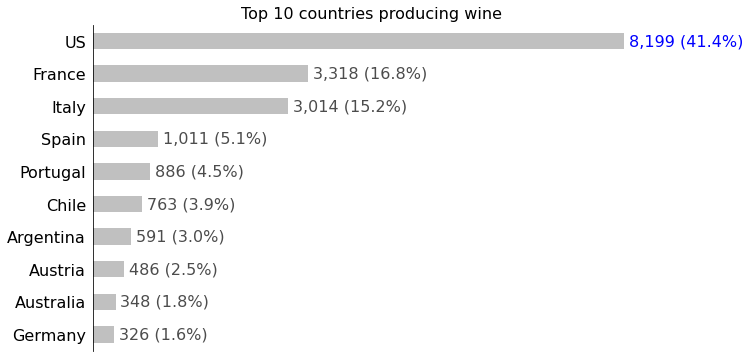

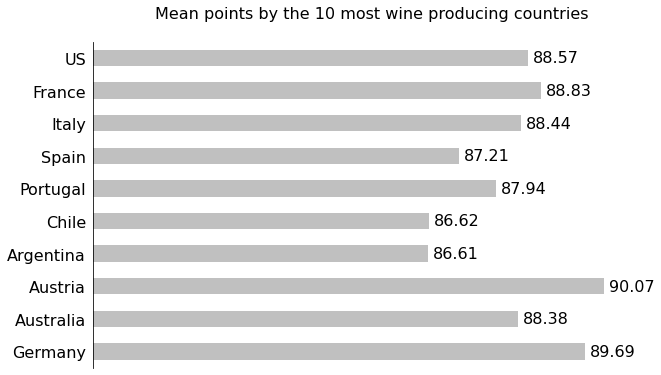

In [17]:
cnt = df['country'].value_counts().iloc[:10].sort_values().reset_index()

fig, ax = plt.subplots(figsize=(10, 6))

cnt.plot(
    kind='barh', x='index', y='country', ax=ax,
    legend=False, fontsize=16, color=[gray]*(len(cnt.index.tolist())-1)
)

style_plot(ax, h=True)

total = df.shape[0]
for y, x in enumerate(cnt['country'].tolist()):
    if y < cnt.shape[0] - 1:
        ax.text(x=x+70, y=y, s=f'{x:,} ({x/total:.1%})', ha='left', va='center', size=16, alpha=.7)
    else:
        ax.text(x=x+70, y=y, s=f'{x:,} ({x/total:.1%})', ha='left', va='center', size=16, color='blue')

ax.set_title('Top 10 countries producing wine', size=16)


main_cnt = cnt['index'].tolist()
points_by_cnt = df.loc[df['country'].isin(main_cnt), :].groupby('country')['points'].mean()
df_tp = pd.concat([cnt.set_index('index'), points_by_cnt], axis=1).sort_values('country').reset_index()

fig, ax = plt.subplots(figsize=(10, 6))

df_tp.plot(
    kind='barh', x='index', y='points', ax=ax,
    legend=False, fontsize=16, color=[gray]*(len(cnt.index.tolist())-1) 
)

style_plot(ax, h=True)
ax.set_xlim(80, 91)

for y, x in enumerate(df_tp['points'].tolist()):
    if y < cnt.shape[0] - 1:
        ax.text(x=x+.1, y=y, s=f'{round(x, 2)}', ha='left', va='center', size=16)
    else:
        ax.text(x=x+.1, y=y, s=f'{round(x, 2)}', ha='left', va='center', size=16)

ax.set_title('Mean points by the 10 most wine producing countries\n', size=16)

plt.show()

In [18]:
df.describe()['points']

count    19802.000000
mean        88.381628
std          3.050416
min         80.000000
25%         86.000000
50%         88.000000
75%         91.000000
max        100.000000
Name: points, dtype: float64

- The US produce more than 40% of wines.

- We can see that quantity is not necessarily a sign of quality since wines from the most producing countries are not, on average, part of the quarter of the best rated wines.

In [19]:
# Top 10 best rated countries in average

round(df.groupby('country')['points'].mean().sort_values(ascending=False).reset_index().head(10),2)

,country,points
0,India,93.00
1,England,92.00
2,Austria,90.07
3,Switzerland,90.00
4,Germany,89.69
5,Canada,89.58
6,Hungary,89.50
7,Lebanon,89.25
8,Luxembourg,89.00
9,France,88.83


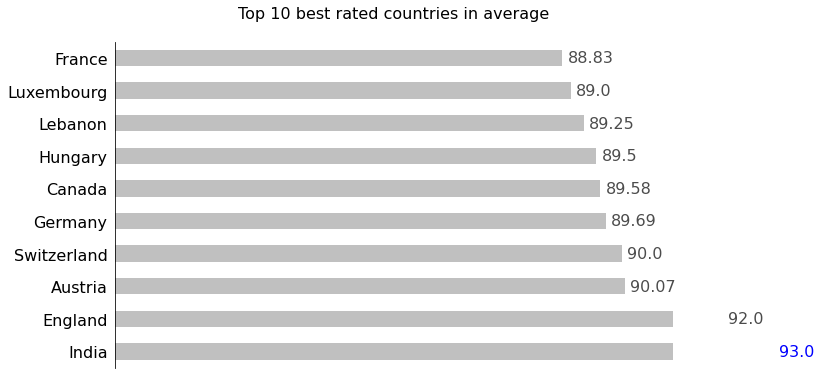

In [20]:
# Top 10 best rated countries in average

best_rated_cnt = df.groupby('country')['points'].mean().sort_values(ascending=False).reset_index().head(10)

fig, ax = plt.subplots(figsize=(10, 6))

best_rated_cnt.plot(
    kind='barh', x='country', y='points', ax=ax,
    legend=False, fontsize=16, color=[gray]*(len(best_rated_cnt.index.tolist())-1) 
)

style_plot(ax, h=True)
ax.set_xlim(80, 91)

for y, x in enumerate(best_rated_cnt['points'].tolist()):
    if y < best_rated_cnt.shape[-1] - 1:
        ax.text(x=x+0.1, y=y, s=f'{round(x, 2)}', ha='left', va='center', size=16, color='blue')
    else:
        ax.text(x=x+0.1, y=y, s=f'{round(x, 2)}', ha='left', va='center', size=16, alpha=.7)


ax.set_title('Top 10 best rated countries in average\n', size=16)

        
plt.show()

In [21]:
# Top 10 best rated wineries in average

round(df.groupby('winery')['points'].mean().sort_values(ascending=False).reset_index().head(10),2)

,winery,points
0,Château La Mission Haut-Brion,97.0
1,Château Haut-Brion,96.5
2,Château Beau-Séjour Bécot,96.0
3,Tenuta dell'Ornellaia,96.0
4,Château Malartic-Lagravière,96.0
5,Château Palmer,96.0
6,Château Valandraud,96.0
7,Château Cheval Blanc,96.0
8,Biondi Santi,96.0
9,Rubicon Estate,96.0


In [22]:
# Top 10 best ratings varieties in average

round(df.groupby('variety')['points'].mean().sort_values(ascending=False).reset_index().head(10),2)

,variety,points
0,Grenache Blend,95.00
1,Muscadelle,94.33
2,Viognier-Roussanne,94.00
3,Tinta del Pais,94.00
4,Tannat-Merlot,94.00
5,Tannat-Cabernet,92.50
6,Muscat Blanc,92.00
7,Nerello Cappuccio,92.00
8,Jaen,92.00
9,Carignan-Grenache,92.00


In [23]:
# Best rated wines

df.loc[df['points'] == 100, ['title','country','winery','variety','points']]

,title,country,winery,variety,points
345,Chambers Rosewood Vineyards NV Rare Muscat (Ru...,Australia,Chambers Rosewood Vineyards,Muscat,100
7335,Avignonesi 1995 Occhio di Pernice (Vin Santo ...,Italy,Avignonesi,Prugnolo Gentile,100


#### Price

In [24]:
# Top 10 countries producing the most expensive wines on average

round(df.groupby('country')['price'].mean().sort_values(ascending=False).reset_index().head(10),2)

,country,price
0,Hungary,58.44
1,England,52.00
2,France,43.29
3,Germany,39.30
4,Canada,38.16
5,Italy,37.76
6,US,36.92
7,Lebanon,36.00
8,Australia,32.57
9,Austria,30.90


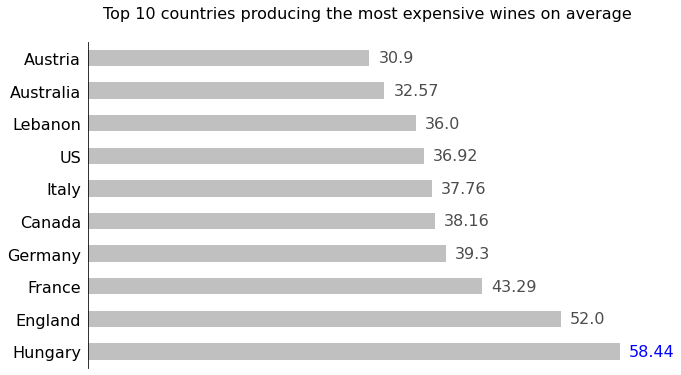

In [25]:
# Top 10 countries producing the most expensive wines on average

most_expensive_cnt = df.groupby('country')['price'].mean().sort_values(ascending=False).reset_index().head(10)
fig, ax = plt.subplots(figsize=(10, 6))

most_expensive_cnt.plot(
    kind='barh', x='country', y='price', ax=ax,
    legend=False, fontsize=16, color=[gray]*(len(most_expensive_cnt.index.tolist()))
)

style_plot(ax, h=True)

for y, x in enumerate(most_expensive_cnt['price'].tolist()):
    if y < most_expensive_cnt.shape[-1] - 1:
        ax.text(x=x+1, y=y, s=f'{round(x, 2)}', ha='left', va='center', size=16, color='blue')
    else:
        ax.text(x=x+1, y=y, s=f'{round(x, 2)}', ha='left', va='center', size=16, alpha=.7)


ax.set_title('Top 10 countries producing the most expensive wines on average\n', size=16)

        
plt.show()

The quality of a wine does not seem to be correlated with its price since, apart from England and France, the countries that produce the most expensive wines are different from those with the highest ratings.

In [26]:
# Top 10 most expensive wines 

df.groupby(['title','country','winery','variety'])['price'].max().sort_values(ascending=False).reset_index().head(10)

,title,country,winery,variety,price
0,Château Pétrus 2014 Pomerol,France,Château Pétrus,Bordeaux-style Red Blend,2500.0
1,Château Margaux 2009 Margaux,France,Château Margaux,Bordeaux-style Red Blend,1900.0
2,Château Mouton Rothschild 2009 Pauillac,France,Château Mouton Rothschild,Bordeaux-style Red Blend,1300.0
3,Château Haut-Brion 2009 Pessac-Léognan,France,Château Haut-Brion,Bordeaux-style Red Blend,1200.0
4,Château La Mission Haut-Brion 2009 Pessac-Léo...,France,Château La Mission Haut-Brion,Bordeaux-style Red Blend,1100.0
5,Robert Weil 2015 Kiedrich Gräfenberg Trockenbe...,Germany,Robert Weil,Riesling,775.0
6,Robert Weil 2014 Kiedrich Gräfenberg Trockenbe...,Germany,Robert Weil,Riesling,775.0
7,Marco Abella 2012 El Perer Carignan (Priorat),Spain,Marco Abella,Carignan,770.0
8,Château La Mission Haut-Brion 2014 Pessac-Léo...,France,Château La Mission Haut-Brion,Bordeaux-style White Blend,698.0
9,Louis Latour 2014 Le Montrachet (Montrachet),France,Louis Latour,Chardonnay,630.0


Most expensive wines come from France.

In [27]:
# Top 10 cheapest wines 

df.groupby(['title','country','winery','variety'])['price'].max().sort_values().reset_index().head(10)

,title,country,winery,variety,price
0,Felix Solis 2013 Flirty Bird Syrah (Vino de la...,Spain,Felix Solis,Syrah,4.0
1,Adega Cooperativa Ponte de Barca 2010 Escolha ...,Portugal,Adega Cooperativa Ponte de Barca,Rosé,5.0
2,Mancan NV Red (California),US,Mancan,Red Blend,5.0
3,Earth's Harvest 2014 Organic Grapes Chardonnay...,US,Earth's Harvest,Chardonnay,5.0
4,Herdade dos Machados 2009 Morgado da Canita Re...,Portugal,Herdade dos Machados,Portuguese Red,5.0
5,Anna Spinato NV Mini (Prosecco),Italy,Anna Spinato,Glera,5.0
6,San Pedro 2002 Gato Negro Cabernet Sauvignon (...,Chile,San Pedro,Cabernet Sauvignon,5.0
7,Belle Made For You NV Red (Vin de France),France,Belle Made For You,Red Blend,5.0
8,Belle Made For You NV Cabernet Sauvignon (Vin ...,France,Belle Made For You,Cabernet Sauvignon,5.0
9,Two Vines 2014 Gewürztraminer (Washington),US,Two Vines,Gewürztraminer,6.0


### Points-to-Price Ratio

In [28]:
# Top 15 best points-to-price ratio

df.groupby('points')['price'].min().sort_values().reset_index().head(15)

,points,price
0,85,4.0
1,83,5.0
2,84,5.0
3,86,5.0
4,82,6.0
5,87,6.0
6,80,7.0
7,81,7.0
8,88,7.0
9,90,8.0


In [29]:
# Top 15 worse points-to-price ratio

df.groupby('points')['price'].max().sort_values(ascending=False).reset_index().head(15)

,points,price
0,96,2500.0
1,98,1900.0
2,97,1100.0
3,95,520.0
4,93,500.0
5,92,450.0
6,94,450.0
7,90,400.0
8,100,350.0
9,87,250.0


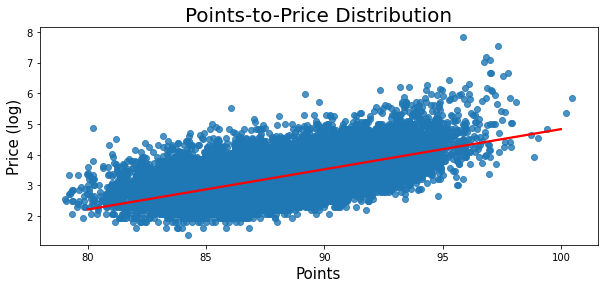

In [30]:
# Points-to-Price Distribution

df['price_log'] = np.log(df['price'])

plt.figure(figsize=(10,4))

g = sns.regplot(x='points', y='price_log', 
                data=df, line_kws={'color':'red'}, x_jitter=True, fit_reg=True)
g.set_title("Points-to-Price Distribution", fontsize=20)
g.set_xlabel("Points", fontsize= 15)
g.set_ylabel("Price (log)", fontsize= 15)

plt.show()

We can notice that the wines with the best price-to-points ratio are the cheapest. However, it was noted earlier that the range of prices is much more larger than that of points. Then, the points_to_price ratio does not seem very relevant here as we can see in the graph below.

### Description

In [31]:
# Let's add a new column : len_description, which corresponds to the total number of words in the description of each wine

df['len_desc'] = [len(word) for word in df.iloc[:,1]]

In [32]:
# Top 10 longer descriptions

df.groupby(['title','price','points'])['len_desc'].max().sort_values(ascending=False).reset_index().head(10)

,title,price,points,len_desc
0,De Toren 2014 Book 17 XVII Red (Stellenbosch),330.0,95,723
1,Williams Selyem 2009 Precious Mountain Vineyar...,94.0,99,690
2,Domaine Marcel Deiss 2012 Schoenenbourg Grand ...,78.0,96,630
3,Sineann 2005 Block One Champoux Vineyard Caber...,72.0,95,614
4,Domaine Zind-Humbrecht 2015 Clos Saint Urbain ...,120.0,96,610
5,Lineage 2007 Red (Livermore Valley),125.0,94,594
6,Nyetimber 2010 Blanc de Blancs Chardonnay (Eng...,70.0,95,572
7,Domaine Zind-Humbrecht 2015 Goldert Grand Cru ...,26.0,95,561
8,Rubicon Estate 2005 Rubicon Red (Rutherford),145.0,96,560
9,Jean Biecher & Fils 2016 Altenberg de Bergheim...,45.0,95,557


In [33]:
# Top 10 shorter descriptions

df.groupby(['title','price','points'])['len_desc'].max().sort_values().reset_index().head(10)

,title,price,points,len_desc
0,Strait Jacket 2007 Sauvignon Blanc-Semillon (W...,20.0,87,35
1,Naches Heights 2006 Riesling (Columbia Valley ...,16.0,82,39
2,Naches Heights 2006 Pinot Gris (Columbia Valle...,16.0,81,51
3,YN NV Red (California),11.0,81,52
4,Center of Effort 2009 Effort Pinot Noir (Edna ...,27.0,82,53
5,Amberhill 2010 Secret Blend White (California),10.0,82,55
6,Paradise Ridge 2003 Rockpile Vineyard Merlot (...,32.0,82,57
7,Jenica Peak 2006 Coastal Series Pinot Grigio (...,10.0,82,61
8,Melrose 2010 Pinot Noir (Umpqua Valley),16.0,81,63
9,Darcie Kent Vineyards 2008 Madden Ranch Petite...,24.0,85,65


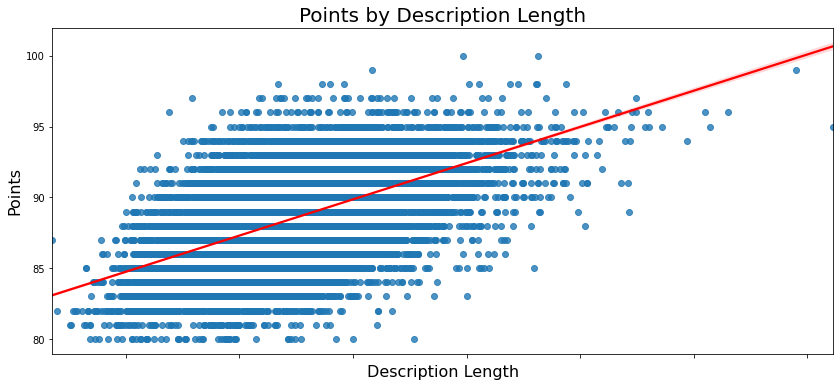

In [34]:
# Points by Description Length

plt.figure(figsize=(14,6))

price_desc = sns.regplot(x='len_desc', y='points', line_kws={'color':'red'},
                data=df, fit_reg=True)
price_desc.set_title('Points by Description Length', fontsize=20)
price_desc.set_ylabel('Points', fontsize = 16) 
price_desc.set_xlabel('Description Length', fontsize = 16)
price_desc.set_xticklabels(price_desc.get_xticklabels(),rotation=45)

plt.show()

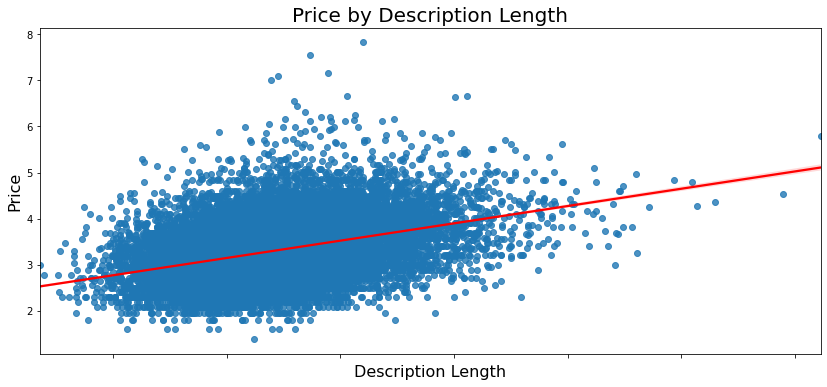

In [35]:
# Price by Description Length

plt.figure(figsize=(14,6))

price_desc = sns.regplot(x='len_desc', y='price_log', line_kws={'color':'red'},
                data=df, fit_reg=True)
price_desc.set_title('Price by Description Length', fontsize=20)
price_desc.set_ylabel('Price', fontsize = 16) 
price_desc.set_xlabel('Description Length', fontsize = 16)
price_desc.set_xticklabels(price_desc.get_xticklabels(),rotation=45)

plt.show()

#### Interesting insights:

- It seems to have a kind of relationship between description length and ratings. Indeed, the first 10 wines with the longest description are among the quarter of the best rated wines. Conversely, the 10 wines with the shortest description are among the wines with below-average ratings.
- The relationship between description length and prices is less obvious.

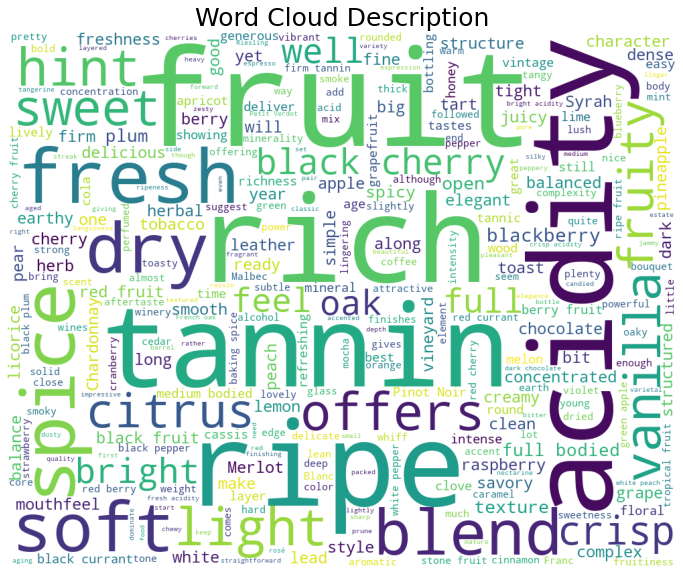

In [36]:
stopwords = set(STOPWORDS)

newStopWords = ['mouth','offer','taste','drink','touch','wine', 'Wine', 'Drink', 'finish', 'now', 'nose', 'palate', 'show', 'flavor', 'flavors', 'shows', 'note', 'Cabernet', 'Sauvignon', 'give', 'aroma', 'aromas', 'notes', 'made', 'come']

stopwords.update(newStopWords)

wordcloud = WordCloud(
    background_color='white',
    stopwords=stopwords,
    max_words=300,
    max_font_size=200, 
    width=1000, height=800,
    random_state=42,
).generate(" ".join(df['description'].astype(str)))

print(wordcloud)
fig = plt.figure(figsize = (12,14))
plt.imshow(wordcloud)
plt.title("Word Cloud Description",fontsize=25)
plt.axis('off')
plt.show()

# 2. Preprocessing

For memory issues, the first version of app will only take into account French wines. 

In [37]:
df = df.loc[df['country']=='France']

In [38]:
df

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,price_log,len_desc
7,France,This dry and restrained wine offers spice in p...,NaN,87,24.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Trimbach 2012 Gewurztraminer (Alsace),Gewürztraminer,Trimbach,3.178054,122
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam,3.295837,160
11,France,"This is a dry wine, very spicy, with a tight, ...",NaN,87,30.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Leon Beyer 2012 Gewurztraminer (Alsace),Gewürztraminer,Leon Beyer,3.401197,179
30,France,Red cherry fruit comes laced with light tannin...,Nouveau,86,NaN,Beaujolais,Beaujolais-Villages,NaN,Roger Voss,@vossroger,Domaine de la Madone 2012 Nouveau (Beaujolais...,Gamay,Domaine de la Madone,NaN,98
42,France,"This is a festive wine, with soft, ripe fruit ...",Nouveau,86,9.0,Beaujolais,Beaujolais,NaN,Roger Voss,@vossroger,Henry Fessy 2012 Nouveau (Beaujolais),Gamay,Henry Fessy,2.197225,83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19941,France,"Produced at Château Haut-Bailly, this concentr...",NaN,89,100.0,Bordeaux,Pessac-Léognan,NaN,Roger Voss,@vossroger,Château le Pape 2011 Pessac-Léognan,Bordeaux-style Red Blend,Château le Pape,4.605170,242
19942,France,"Rich and smooth, this is a good example of the...",NaN,89,55.0,Bordeaux,Médoc,NaN,Roger Voss,@vossroger,Château le Temple 2009 Médoc,Bordeaux-style Red Blend,Château le Temple,4.007333,209
19943,France,"Complex and powerful, this wood-aged red has b...",Les Forts de Léoube,89,32.0,Provence,Côtes de Provence,NaN,Roger Voss,@vossroger,Château Léoube 2010 Les Forts de Léoube Red (C...,Rhône-style Red Blend,Château Léoube,3.465736,217
19947,France,"Lively, crisp wine from an estate founded by t...",NaN,89,19.0,Provence,Coteaux d'Aix-en-Provence,NaN,Roger Voss,@vossroger,Commanderie de la Bargemone 2012 Rosé (Coteaux...,Rosé,Commanderie de la Bargemone,2.944439,168


## Spacy

spaCy is a relatively new package for performant and advanced Natural Language Processing tasks. It is a free, open-source library developed for Python.

Differently from NLTK, which was conceived for teaching and research purposes, spaCy was designed with the applied data science concepts in mind.

The nlp object does not only parse the tokens in the text, but it also stores many charateristics and attributes for each token, including:

- Whether it's an alphabetic token
- Whether it's a number
- Whether it's a punctuation
- Token's lemma
- And others 

Let's see how spaCy outputs these features:

In [39]:
# Take the first description as an example

nlp = spacy.load("en_core_web_md")
sent_1 = df['description'][7]
doc_1 = nlp(sent_1)

# Printing the index of each token in the first description
print('Index:   ', [token.i for token in doc_1])

# Printing the raw text representation of each token
print('Text:    ', [token.text for token in doc_1])

# Pritting the token's lemma
print('Lemma:   ', [token.lemma_ for token in doc_1])          # -PRON- is used as the lemma for all personal pronouns

# Whether each token is alphabetic or not
print('is_alpha:', [token.is_alpha for token in doc_1])

# Whether each token is a number or not
print('like_num:', [token.like_num for token in doc_1]) 

# Whether each token is a punctuation or not
print('is_punct:', [token.is_punct for token in doc_1])

Index:    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
Text:     ['This', 'dry', 'and', 'restrained', 'wine', 'offers', 'spice', 'in', 'profusion', '.', 'Balanced', 'with', 'acidity', 'and', 'a', 'firm', 'texture', ',', 'it', "'s", 'very', 'much', 'for', 'food', '.']
Lemma:    ['this', 'dry', 'and', 'restrained', 'wine', 'offer', 'spice', 'in', 'profusion', '.', 'balance', 'with', 'acidity', 'and', 'a', 'firm', 'texture', ',', '-PRON-', 'be', 'very', 'much', 'for', 'food', '.']
is_alpha: [True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, False, True, False, True, True, True, True, False]
like_num: [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
is_punct: [False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False

### Part of Speech Tagging (POS)

Part of Speech (POS) is a category of words with similar grammatical properties. Examples: noun, verb, adjective, adverb.

Part of Speech tagging, also called grammatical tagging, is the process of marking up a word in a text as corresponding to a particular part of speech based on both its definition and its context.


In [40]:
for token in doc_1:
    print(token.text + ' => ' + 
          token.pos_ + ' (' + spacy.explain(token.pos_) + ') - ' + 
          token.tag_ + ' (' + spacy.explain(token.tag_) + ')')

This => DET (determiner) - DT (determiner)
dry => ADJ (adjective) - JJ (adjective)
and => CCONJ (coordinating conjunction) - CC (conjunction, coordinating)
restrained => ADJ (adjective) - JJ (adjective)
wine => NOUN (noun) - NN (noun, singular or mass)
offers => VERB (verb) - VBZ (verb, 3rd person singular present)
spice => NOUN (noun) - NN (noun, singular or mass)
in => ADP (adposition) - IN (conjunction, subordinating or preposition)
profusion => NOUN (noun) - NN (noun, singular or mass)
. => PUNCT (punctuation) - . (punctuation mark, sentence closer)
Balanced => VERB (verb) - VBN (verb, past participle)
with => ADP (adposition) - IN (conjunction, subordinating or preposition)
acidity => NOUN (noun) - NN (noun, singular or mass)
and => CCONJ (coordinating conjunction) - CC (conjunction, coordinating)
a => DET (determiner) - DT (determiner)
firm => ADJ (adjective) - JJ (adjective)
texture => NOUN (noun) - NN (noun, singular or mass)
, => PUNCT (punctuation) - , (punctuation mark, comm

### Named Entity Recognition (NER)

Named entity recognition (NER) is the task of tagging entities in text with pre-defined categories such as the names of persons, organizations, locations, expressions of times, quantities, monetary values, percentages, etc. 

In [41]:
displacy.render(doc_1, style="ent")

/home/mona_lisa/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/spacy/displacy/__init__.py:189: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


In [42]:
# Let's preprocess with spacy in order to remove stop-words, punctuation, uppercases etc.

In [43]:
def preprocess_spacy(sent):
    doc = nlp(sent)
    filtered_tokens = [token.lemma_.lower() for token in doc if token.is_alpha and not token.is_stop]
    filtered_tokens = [token for token in filtered_tokens if token not in stopwords]
    return ' '.join(filtered_tokens)

In [44]:
%%time
df['preprocessed_text_spacy'] = df.description.apply(preprocess_spacy)

CPU times: user 33.9 s, sys: 27.5 ms, total: 33.9 s
Wall time: 33.9 s


In [45]:
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,price_log,len_desc,preprocessed_text_spacy
7,France,This dry and restrained wine offers spice in p...,NaN,87,24.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Trimbach 2012 Gewurztraminer (Alsace),Gewürztraminer,Trimbach,3.178054,122,dry restrained spice profusion balance acidity...
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam,3.295837,160,great depth fresh apple pear fruit spice dry b...
11,France,"This is a dry wine, very spicy, with a tight, ...",NaN,87,30.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Leon Beyer 2012 Gewurztraminer (Alsace),Gewürztraminer,Leon Beyer,3.401197,179,dry spicy tight taut texture strongly mineral ...
30,France,Red cherry fruit comes laced with light tannin...,Nouveau,86,NaN,Beaujolais,Beaujolais-Villages,NaN,Roger Voss,@vossroger,Domaine de la Madone 2012 Nouveau (Beaujolais...,Gamay,Domaine de la Madone,NaN,98,red cherry fruit lace light tannin bright open...
42,France,"This is a festive wine, with soft, ripe fruit ...",Nouveau,86,9.0,Beaujolais,Beaujolais,NaN,Roger Voss,@vossroger,Henry Fessy 2012 Nouveau (Beaujolais),Gamay,Henry Fessy,2.197225,83,festive soft ripe fruit acidity plus red berry


# 3. Modeling

### Bag of Words (BOW)

A bag of words (BOW) is just a vector keeping the information of how many times each word has been encountered in a text. 

In [46]:
data = df['preprocessed_text_spacy']

In [47]:
vectorizer = CountVectorizer(max_features=1000)
BOW = vectorizer.fit_transform(data).toarray()
BOW.shape

(3318, 1000)

In [48]:
print(BOW)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [49]:
BOW.sum(axis=1)

array([ 8, 12, 14, ..., 18, 12, 17])

In [50]:
tokens = vectorizer.get_feature_names()
print(tokens)

['ability', 'absolute', 'accent', 'accessible', 'accompany', 'acid', 'acidic', 'acidity', 'acre', 'act', 'add', 'addition', 'additional', 'aftertaste', 'age', 'aged', 'ageworthy', 'aging', 'alain', 'alcohol', 'allow', 'ally', 'almond', 'alongside', 'ample', 'apart', 'apparent', 'appeal', 'appear', 'appellation', 'appetizing', 'apple', 'approach', 'approachable', 'apricot', 'apéritif', 'area', 'aromatic', 'asian', 'aspect', 'attractive', 'attractively', 'aube', 'austere', 'away', 'back', 'backbone', 'backdrop', 'background', 'bake', 'baking', 'balance', 'balanced', 'balancing', 'balm', 'banana', 'bank', 'barnyard', 'barrel', 'base', 'bear', 'beaujolais', 'beaune', 'beautiful', 'beautifully', 'begin', 'beneath', 'benefit', 'bergamot', 'bergerac', 'berry', 'big', 'biodynamic', 'bit', 'bite', 'bitter', 'bitterness', 'black', 'blackberry', 'blanc', 'blancs', 'blend', 'blossom', 'blow', 'blueberry', 'boast', 'bodied', 'body', 'bold', 'bone', 'boost', 'bordeaux', 'botrytis', 'bottle', 'bottli

In [51]:
bow_df = pd.DataFrame(data=BOW, columns=tokens)
bow_df

,ability,absolute,accent,accessible,accompany,acid,acidic,acidity,acre,act,...,yes,yield,young,youth,youthful,zest,zestiness,zesty,zingy,émilion
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3313,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3314,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3315,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3316,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
# The 10 most used word

bow_df.sum().sort_values(ascending=False)[:10]

fruit        2436
acidity      1538
ripe         1298
tannin       1077
rich          860
age           708
red           701
texture       675
character     624
structure     612
dtype: int64

## TF-IDF

In [53]:
TIvectorizer = TfidfVectorizer(max_features=1000)
tf_idf = TIvectorizer.fit_transform(data).toarray()
tf_idf = pd.DataFrame(data=tf_idf, columns=TIvectorizer.get_feature_names())
tf_idf

,ability,absolute,accent,accessible,accompany,acid,acidic,acidity,acre,act,...,yes,yield,young,youth,youthful,zest,zestiness,zesty,zingy,émilion
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.168149,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166746,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.209957,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3313,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3314,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.113103,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.137572,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
tf_idf.shape

(3318, 1000)

In [55]:
tf_idf.sum(axis=1)

0       2.625907
1       3.328870
2       3.652556
3       3.002560
4       2.358941
          ...   
3313    4.180681
3314    3.864740
3315    4.043419
3316    3.252619
3317    3.937254
Length: 3318, dtype: float64

In [56]:
tf_idf.sum().sort_values(ascending=False)[:10]

fruit        219.644989
acidity      176.927883
ripe         159.119584
tannin       147.377336
rich         123.550275
red          115.509826
age          110.248226
fruity       107.422064
texture      107.157632
character    105.398786
dtype: float64

## Cosine Similarity

In [57]:
%%time
cosine_sim = cosine_similarity(tf_idf, tf_idf)

CPU times: user 1.26 s, sys: 87.8 ms, total: 1.35 s
Wall time: 395 ms


In [58]:
#cosine_sim.argsort()

# 4. Model Prediction

In [59]:
indices = pd.Series(df.index, index=df['title'])

In [60]:
def get_recommandations(title, cosine_sim=cosine_sim):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    wine_indices = [i[0] for i in sim_scores]
    return df['title'].iloc[wine_indices]

In [61]:
get_recommandations('Leon Beyer 2012 Gewurztraminer (Alsace)', cosine_sim)

19673    Union de Vignerons de l'Île de Beauté 2016 Ter...
7588                 Pommery NV POP Extra Dry  (Champagne)
8755     Domaine Cauhapé 2012 Ballet d'Octobre  (Jurançon)
3483     La Cave des Vignerons de Pfaffenheim 2009 Pino...
12428    Domaine de la Perruche NV La Grande Cuvée  (Sa...
8247     Wolfberger 2008 Rangen Grand Cru Pinot Gris (A...
9279                Domaine du Théron 2014 Malbec (Cahors)
12424    Champagne Gremillet NV Sélection Brut  (Champa...
14273      Domaine des Nugues 2011 Gamay (Beaujolais Rosé)
12202    Winenot 2014 Les Jolies Filles Rosé (Côtes de ...
Name: title, dtype: object

In [62]:
df.loc[df['title'] == 'Leon Beyer 2012 Gewurztraminer (Alsace)']['description'].tolist()

["This is a dry wine, very spicy, with a tight, taut texture and strongly mineral character layered with citrus as well as pepper. It's a food wine with its almost crisp aftertaste."]

In [63]:
df.loc[df['title'] == 'Château Anniche 2014  Bordeaux Blanc']['description'].tolist()

['This steely, tangy wine has a strongly mineral character—tight, taut and crisp. Green fruits, citrus and a grassy character dominate. It is ready to drink. This is an unusual 75% Sémillion and 25% Sauvignon Blanc blend that tends to round out the taste.']

In [64]:
df.loc[df['title'] == 'Pierre Morey 2005 Les Tessons  (Meursault)']['description'].tolist()

['Powerful wine, structured with apple skin tannins, layers of ripe, spicy toast and a taut, mineral character. There is something of the Meursault richness here, in the full white fruit flavors, but this is also a wine that needs to age.']

# 5. Deployment

In [68]:
df['price'].fillna('-', inplace=True)

In [69]:
tf_idf = tf_idf.astype('float16')

filepath = os.path.join('..', 'data', 'tf_idf_wine.pkl')
tf_idf.to_pickle(filepath)

In [70]:
filepath = os.path.join('..', 'data', 'wine_titles.pkl')
df[['title','description','price','province']].to_pickle(filepath)